## 시작하기 전에 ...
### cmd 창에 pip install ksif를 해주어야 함!
#### Jupyter Notebook에서 바로 다운로드 하려면?? 코드 치는 부분에서 !pip install ksif 하면 됨!

In [98]:
import math
import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from datetime import datetime
import ksif
from ksif import Portfolio
import random
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [99]:
pf = Portfolio()

In [100]:
name1 = '삼성전자'
name2 = 'NAVER'
name3 = 'SK하이닉스'

In [101]:
data1 = pf[pf['firmname'] == name1]
data2 = pf[pf['firmname'] == name2]
data3 = pf[pf['firmname'] == name3]

In [102]:
data1 = data1[data1['date'] > datetime(2015, 4, 1)]
data2 = data2[data2['date'] > datetime(2015, 4, 1)]
data3 = data3[data3['date'] > datetime(2015, 4, 1)]

In [103]:
# 구해야 하는 것. 
#1. expected return (평균 return)
#2. 주가의 표준편차(시그마)
#3. Covariance
#4. Risk-free rate
filtered_data1 = pd.DataFrame()
filtered_data1['firmname'] = data1['firmname']
filtered_data1['date'] = data1['date']
filtered_data1['ret'] = data1['ret']

filtered_data2 = pd.DataFrame()
filtered_data2['firmname'] = data2['firmname']
filtered_data2['date'] = data2['date']
filtered_data2['ret'] = data2['ret']

filtered_data3 = pd.DataFrame()
filtered_data3['firmname'] = data3['firmname']
filtered_data3['date'] = data3['date']
filtered_data3['ret'] = data3['ret']

#filtered_data1 = data1[['firmname', 'date', 'ret']]
#filtered_data2 = data2[['firmname', 'date', 'ret']]
#filtered_data3 = data3[['firmname', 'date', 'ret']]
len(filtered_data1)
len(filtered_data2)
len(filtered_data3)

60

60

60

In [104]:
# 각 주식 별 평균
expected_return1 = data1['ret'].mean()
expected_return2 = data2['ret'].mean()
expected_return3 = data3['ret'].mean()

# Annualized arithmatic returns for each stocks - a번 정답
Annual_average_return1 = expected_return1*12
Annual_average_return2 = expected_return2*12
Annual_average_return3 = expected_return3*12

# 각 주식 별 분산
volatility1 = math.sqrt(data1['ret'].var())
volatility2 = math.sqrt(data2['ret'].var())
volatility3 = math.sqrt(data3['ret'].var())

# Annualized standard deviation for each stocks - b번 정답
Annual_sd1 = volatility1 * math.sqrt(12)
Annual_sd2 = volatility2 * math.sqrt(12)
Annual_sd3 = volatility3 * math.sqrt(12)

In [105]:
# 공분산 구하기
filtered_data1.reset_index(inplace = True) 
filtered_data2.reset_index(inplace = True) 
filtered_data3.reset_index(inplace = True) 
corr12 = filtered_data1['ret'].corr(filtered_data2['ret'])
corr23 = filtered_data2['ret'].corr(filtered_data3['ret'])
corr13 = filtered_data3['ret'].corr(filtered_data1['ret'])

In [106]:
# input
risk_free_ratio = 0.00002 #이건 일단 임의로 설정.
total_return = np.array([expected_return1, expected_return2, expected_return3])
std = np.array([volatility1, volatility2, volatility3])
rho = np.array([corr12, corr23, corr13]) #상관계수

In [107]:
risk_premium = total_return - risk_free_ratio
risk_premium = np.array(risk_premium)
risk_premium

array([0.01117883, 0.00737117, 0.0140841 ])

In [108]:
corrm = np.array([[1, rho[0],rho[2]],[rho[0],1,rho[1]],[rho[2], rho[1],1]])
sdm = np.zeros((3,3))

In [109]:
sdm[0][0] = std[0]
sdm[1][1] = std[1]
sdm[2][2] = std[2]

In [110]:
def np_vcov_matrix(sdm, corrm): #분산-공분산 행렬 구하는 함수
    return (sdm.dot(corrm)).dot(sdm)
vcov = np_vcov_matrix(sdm, corrm) 

In [111]:
vcov

array([[0.00502748, 0.00238408, 0.00336673],
       [0.00238408, 0.0073782 , 0.00094084],
       [0.00336673, 0.00094084, 0.00822872]])

In [112]:
# sharp ratio 계산
sharp_ratio = []
for i in range(len(std)):
    sharp_ratio.append(risk_premium[i]/std[i])
sharp_ratio = np.array(sharp_ratio)

In [113]:
# Mean-Variance Frontier
w1_range = []
p_std = []
p_mean = []
_max = 100
for i in range(0, _max+1, 1):
    w1_range.append(i/_max)
w1_N = len(w1_range)
w_ratio = []
for i in range(len(w1_range)):
    for j in range(len(w1_range)):
        a = w1_range[i]
        b = w1_range[j]
        c = 1 - a - b
        if(c < 0):
            continue
        else:
            w_ratio.append([a, b, c])
for i in range(len(w_ratio)):
    for j in range(3):
        w_ratio[i][j] = w_ratio[i][j]
for i in range(0, len(w_ratio), 10):
    p_mean.append(np.array(w_ratio[i]).dot(np.transpose(total_return)))
    p_std.append(math.sqrt(np.array(w_ratio[i]).dot(vcov).dot(np.transpose(np.array(w_ratio[i])))))

In [114]:
def res_func(a, b):
    mean = np.array([a, b, 1-a-b]).dot(np.transpose(total_return))
    std = math.sqrt((np.array([a, b, 1-a-b]).dot(vcov)).dot(np.transpose(np.array([a, b, 1-a-b]))))
    sharp = (mean-risk_free_ratio)/std
    return sharp, mean, std

result_a = 0
result_b = 0
result_sharp = 0
result_mean = 0
result_std = 0
for i in range(len(w_ratio)):
    cand_sharp, cand_mean, cand_std = res_func(w_ratio[i][0], w_ratio[i][1])
    if(cand_sharp > result_sharp):
        result_sharp = cand_sharp
        result_a = w_ratio[i][0]
        result_b = w_ratio[i][1]
        result_mean = cand_mean
        result_std = cand_std

In [115]:
line = np.array(p_std)*result_sharp

Text(0.5, 0.98, 'Efficient Frontier & Optimal Line')

Text(0.5, 0, 'Standard Deviation')

Text(0, 0.5, 'Expected Return')

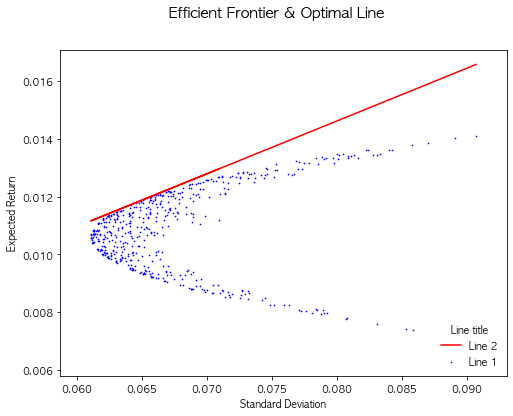

In [116]:
x = p_std
y1 = p_mean
y2 = line
fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Efficient Frontier & Optimal Line', fontsize=15)
#plt.xlim(0, 0.15)
#plt.ylim(0, 0.02)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
ax.scatter(x, y1, color = 'blue', label="Line 1", s = 0.5)
ax.plot(x, y2, color = 'red', label="Line 2")
plt.legend(loc="lower right", title="Line title", frameon=False)
plt.show()

In [117]:
result_sharp
result_a
result_b
result_mean
result_std

0.18277610133317448

0.43

0.16

0.011780765897063526

0.06434520602682813

In [118]:
print("Optimal portfolio weights : %.2f, %.2f, %.2f\nReturn for optimal portfolio : %.5f\nStandard Deviation for optimal portfolio: %.5f\nSharp Ratio for optimal portfolio : %.5f" 
      %(result_a, result_b, 1-result_a-result_b, result_mean + risk_free_ratio, result_std, result_sharp))

Optimal portfolio weights : 0.43, 0.16, 0.41
Return for optimal portfolio : 0.01180
Standard Deviation for optimal portfolio: 0.06435
Sharp Ratio for optimal portfolio : 0.18278


# e번 문제 풀기

In [119]:
# Mean-Variance Frontier
w1_range2 = []
p_std2 = []
p_mean2 = []
_max = 100
for i in range(20, _max+1, 1):
    w1_range2.append(i/_max)
w1_N2 = len(w1_range2)
w_ratio2 = []
for i in range(len(w1_range2)):
    for j in range(len(w1_range2)):
        a = w1_range2[i]
        b = w1_range2[j]
        c = 1 - a - b
        if(c < 0 or c < 0.2):
            continue
        else:
            w_ratio2.append([a, b, c])
for i in range(len(w_ratio2)):
    for j in range(3):
        w_ratio2[i][j] = w_ratio2[i][j]
for i in range(0, len(w_ratio2), 10):
    p_mean2.append(np.array(w_ratio2[i]).dot(np.transpose(risk_premium)))
    p_std2.append(math.sqrt(np.array(w_ratio2[i]).dot(vcov).dot(np.transpose(np.array(w_ratio2[i])))))

In [120]:
result_a2 = 0
result_b2 = 0
result_sharp2 = 0
result_mean2 = 0
result_std2 = 0
for i in range(len(w_ratio2)):
    cand_sharp, cand_mean, cand_std = res_func(w_ratio2[i][0], w_ratio2[i][1])
    if(cand_sharp > result_sharp2):
        result_sharp2 = cand_sharp
        result_a2 = w_ratio2[i][0]
        result_b2 = w_ratio2[i][1]
        result_mean2 = cand_mean
        result_std2 = cand_std

In [121]:
line2 = np.array(p_std2)*result_sharp2

Text(0.5, 0.98, 'Efficient Frontier & Optimal Line')

Text(0.5, 0, 'Standard Deviation')

Text(0, 0.5, 'Expected Return')

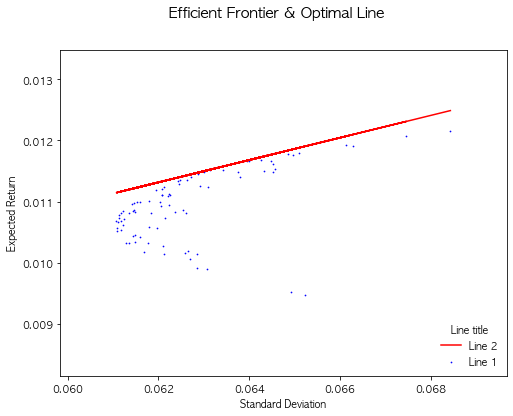

In [122]:
x = p_std2
y1 = p_mean2
y2 = line2
fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Efficient Frontier & Optimal Line', fontsize=15)
#plt.xlim(0.03, 0.12)
#plt.ylim(0.005, 0.0175)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
ax.scatter(x, y1, color = 'blue', label="Line 1", s = 0.5)
ax.plot(x, y2, color = 'red', label="Line 2")
plt.legend(loc="lower right", title="Line title", frameon=False)
plt.show()

In [123]:
print("Optimal portfolio weights : %.2f, %.2f, %.2f\nReturn for optimal portfolio : %.5f\nStandard Deviation for optimal portfolio: %.5f\nSharp Ratio for optimal portfolio : %.5f" 
      %(result_a2, result_b2, 1-result_a2-result_b2, result_mean2 + risk_free_ratio, result_std2, result_sharp2))

Optimal portfolio weights : 0.40, 0.20, 0.40
Return for optimal portfolio : 0.01162
Standard Deviation for optimal portfolio: 0.06345
Sharp Ratio for optimal portfolio : 0.18251


# f. VaR(Value at Risk) & ES(Expected Shortfall)

### 여기서 회사별 데이터의 갯수가 60개이니, 5%를 구하려면 작은 순 3개를 기준으로 보면 됨.
VaR의 경우에는 정규분포라고 가정하였으니, VaR[a%] = E[r] + z*sigma를 하면 됨.
ES의 경우에는 1~3번째의 평균을 보면 됨

In [124]:
total_data = pd.DataFrame()
total_data['A'] = filtered_data1['ret']
total_data['B'] = filtered_data2['ret']
total_data['C'] = filtered_data3['ret']
total_data['pf'] = result_a*total_data['A'] + result_b*total_data['B'] + (1-result_a-result_b)*total_data['C']

In [125]:
total_data

,A,B,C,pf
0,-0.021513,-3.129657e-02,1.317234e-02,-0.008857
1,-0.073050,-6.307692e-02,1.072589e-01,0.002473
2,-0.029839,4.105090e-02,-1.722114e-01,-0.076869
3,-0.065457,-1.750789e-01,-1.229314e-01,-0.106561
4,-0.081013,-5.258126e-02,-3.504043e-02,-0.057615
5,0.041322,3.531786e-02,-6.284916e-02,-0.002349
6,0.209877,1.695906e-01,-8.494784e-02,0.082553
7,-0.064140,5.166667e-02,2.931596e-02,-0.007294
8,-0.018692,4.278922e-02,-2.689873e-02,-0.012220
9,-0.087302,-4.559271e-02,-1.121951e-01,-0.090835


In [126]:
total_data = total_data.sort_values(by = ['pf'], axis = 0)
total_data

,A,B,C,pf
49,-0.073064,-6.694561e-02,-1.734177e-01,-0.113230
3,-0.065457,-1.750789e-01,-1.229314e-01,-0.106561
42,-0.087191,-2.071760e-01,-6.703146e-02,-0.098123
44,-0.075269,-3.557312e-02,-1.307471e-01,-0.091664
9,-0.087302,-4.559271e-02,-1.121951e-01,-0.090835
31,-0.077705,-1.051454e-01,-6.569343e-02,-0.077171
2,-0.029839,4.105090e-02,-1.722114e-01,-0.076869
59,-0.119004,-2.298851e-02,-5.233220e-02,-0.076306
41,-0.041280,-4.787234e-02,-1.192771e-01,-0.074313
22,-0.025849,2.374670e-02,-1.303538e-01,-0.060761


In [127]:
# VaR
VaR_pf = total_data['pf'].mean() + (-1.65)*math.sqrt(total_data['pf'].var())
VaR_pf
# ES -> 60개 data의 5%니까 3번째까지 평균을 구하면 됨.
ES_pf = (total_data['pf'].loc[0] + total_data['pf'].loc[1] + total_data['pf'].loc[2])/3
ES_pf

-0.09438882404720285

-0.027751407850886728

# g. Risk aversion을 고려하여 risky/risk-free 비율 정하기
*주의 : 이 데이터는 현재 e번에서 설정한 데이터일 가능성이 높음. 필요시 변경바람.

y = (E[rp] - rf)/(A*volatility^2)

In [128]:
risk_aversion1 = 2
risk_aversion2 = 3.5
risk_aversion3 = 5

y1 = (result_mean - risk_free_ratio)/(risk_aversion1*(result_std**2))
y2 = (result_mean - risk_free_ratio)/(risk_aversion2*(result_std**2))
y3 = (result_mean - risk_free_ratio)/(risk_aversion3*(result_std**2))

y1 = float(y1)
y2 = float(y2)
y3 = float(y3)

In [129]:
print("risk asset ratio where risk_aversion = 2 : %.2f" %(y1))
print("risk asset ratio where risk_aversion = 3.5 : %.2f" %(y2))
print("risk asset ratio where risk_aversion = 5 : %.2f" %(y3))

risk asset ratio where risk_aversion = 2 : 1.42
risk asset ratio where risk_aversion = 3.5 : 0.81
risk asset ratio where risk_aversion = 5 : 0.57
